In [ ]:
import GWPhotonCounting
import jax.numpy as jnp

import matplotlib.pyplot as plt

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(frequencies, 'data/CE1_shot_psd.csv', 'data/CE1_classical_quanta.csv', 
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

In [8]:
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()

In [9]:
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()

#noise_likelihood = GWPhotonCounting.distributions.GeometricPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()

mixture_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)


In [10]:
observed_photons = jnp.zeros(detector.N_total_filters)

observed_photons = observed_photons.at[30].set(1)

In [11]:
print(detector.noise_photon_expectation[30])

0.001298176427483993


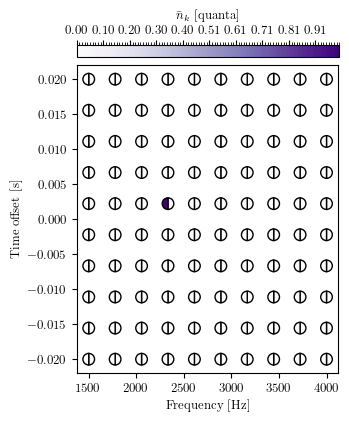

In [12]:
fig = GWPhotonCounting.plotting.generate_count_plot(observed_photons, detector)

In [ ]:
import numpyro
import jax
import numpy as np
import numpyro.infer.initialization as init
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az


def model(n_true_bank):
    
    A = numpyro.sample('A', dist.Uniform(0,1e-19))
    f0 = numpyro.sample('f0', dist.Uniform(1.5e3, 4e3))
    gamma = numpyro.sample('gamma', dist.Uniform(0, 400))
    phase = numpyro.sample('phase', dist.Uniform(0,jnp.pi)) # TODO maybe this only needs to be half of the range
    t0s = jnp.linspace(-0.02, 0.02, 100)
    
    n_pm_model = LorentzianModel.generate_photon_count(detector, frequencies, f0=f0, gamma=gamma, A=A, phase=phase, t0=t0s)
    
    
    log_likelihood_noise = noise_likelihood(n_true_bank, detector.noise_photon_expectation)

    log_likelihood_postmerger = mixture_likelihood(n_true_bank, n_pm_model, detector.noise_photon_expectation)
    
    numpyro.factor('log_likelihood', log_likelihood_postmerger - log_likelihood_noise)
    #numpyro.factor('log_likelihood', log_likelihood_postmerger)

def model_poisson(n_true_bank):
    
    A = numpyro.sample('A', dist.Uniform(0,1e-19))
    f0 = numpyro.sample('f0', dist.Uniform(1.5e3, 4e3))
    gamma = numpyro.sample('gamma', dist.Uniform(0, 400))
    phase = numpyro.sample('phase', dist.Uniform(0,jnp.pi)) # TODO maybe this only needs to be half of the range
    t0s = jnp.linspace(-0.02, 0.02, 100)
    
    n_pm_model = LorentzianModel.generate_photon_count(detector, frequencies, f0=f0, gamma=gamma, A=A, phase=phase, t0=t0s)

    log_likelihood_postmerger = poisson_likelihood(n_true_bank, n_pm_model)
    
    numpyro.factor('log_likelihood', log_likelihood_postmerger)

: 

In [ ]:
n_warmup = 1000
n_sample = 2000
n_chains = 2

kernel = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)


fits_lorentzian = []
n_photons = np.linspace(0, 5, 6)
for n_photon in n_photons:
    mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), observed_photons * n_photon)
    fits_lorentzian.append(az.from_numpyro(mcmc))
    
    print('\n Observed photons: ', n_photon)
    mcmc.print_summary()


/local/ethan.payne/ipykernel_3884309/1854499587.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
  0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
kernel = NUTS(model_poisson, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)


fits_lorentzian_poisson = []
n_photons = np.linspace(0, 5, 6)
for n_photon in n_photons:
    mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), observed_photons * n_photon)
    fits_lorentzian_poisson.append(az.from_numpyro(mcmc))
    
    print('\n Observed photons: ', n_photon)
    mcmc.print_summary()

/local/ethan.payne/ipykernel_36868/2626324196.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
sample: 100%|██████████| 3000/3000 [00:27<00:00, 107.47it/s, 7 steps of size 3.31e-01. acc. prob=0.88] 



 Observed photons:  0.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   2457.32      1.00
        f0   2988.76    668.54   3095.14   1967.41   3999.73   2031.30      1.00
     gamma    237.91    105.22    247.34     84.87    400.00   1832.49      1.00
     phase      1.58      0.91      1.59      0.22      3.03   2558.70      1.00

Number of divergences: 3


sample: 100%|██████████| 3000/3000 [00:29<00:00, 100.72it/s, 7 steps of size 3.17e-01. acc. prob=0.91] 



 Observed photons:  1.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   1258.22      1.00
        f0   2443.74    289.14   2390.66   2043.71   2923.11   1166.05      1.00
     gamma    241.90    104.22    251.64     90.09    399.98   1362.44      1.00
     phase      1.56      0.88      1.56      0.12      2.91   2143.99      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:28<00:00, 106.20it/s, 7 steps of size 3.32e-01. acc. prob=0.93] 



 Observed photons:  2.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   1782.07      1.00
        f0   2384.61    150.39   2371.25   2148.25   2599.87   1370.21      1.00
     gamma    219.89    103.60    219.66     72.11    393.91   1579.20      1.00
     phase      1.58      0.80      1.58      0.40      3.04   2843.39      1.00

Number of divergences: 1


sample: 100%|██████████| 3000/3000 [00:24<00:00, 123.86it/s, 15 steps of size 4.04e-01. acc. prob=0.86]



 Observed photons:  3.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   1688.05      1.00
        f0   2366.00    103.10   2357.09   2210.05   2527.70   1554.54      1.00
     gamma    204.79     96.47    196.15     61.07    370.02   1369.38      1.00
     phase      1.55      0.73      1.54      0.10      2.62   2911.31      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:27<00:00, 109.06it/s, 15 steps of size 3.51e-01. acc. prob=0.94]



 Observed photons:  4.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   1363.65      1.00
        f0   2363.68     93.71   2357.80   2216.20   2490.23   1038.46      1.00
     gamma    188.17     93.70    171.00     47.98    343.50   1040.16      1.00
     phase      1.58      0.66      1.57      0.41      2.69   2605.01      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:31<00:00, 96.53it/s, 3 steps of size 2.99e-01. acc. prob=0.95]  



 Observed photons:  5.0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.00      0.00      0.00      0.00      0.00   1648.09      1.00
        f0   2358.51     73.83   2354.94   2234.86   2476.40   1663.21      1.00
     gamma    179.09     88.47    161.80     47.73    327.90   1280.11      1.00
     phase      1.56      0.62      1.56      0.59      2.71   2396.61      1.00

Number of divergences: 0


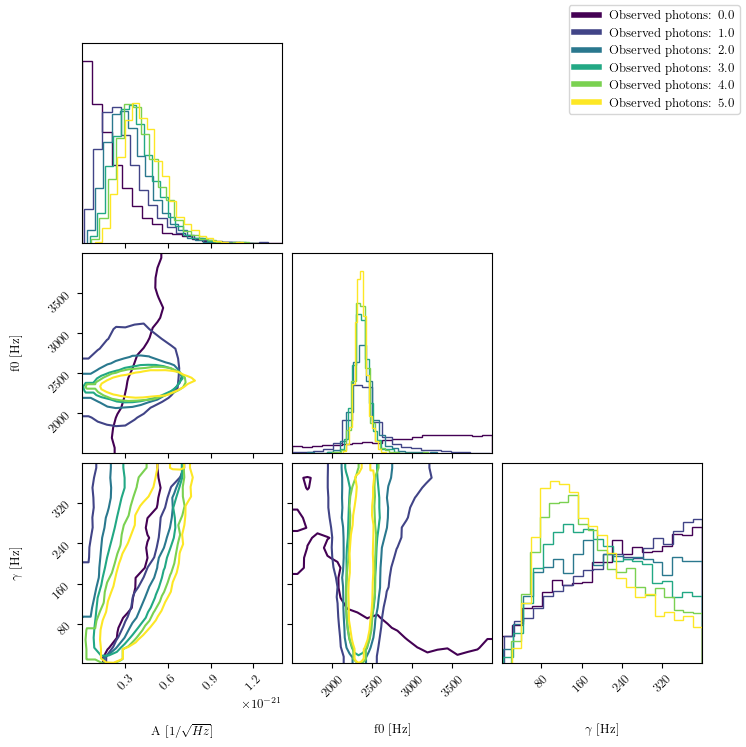

In [15]:
from corner import corner
import matplotlib
from matplotlib.lines import Line2D


cmap = matplotlib.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(fits_lorentzian)))

legend_labels = [Line2D([0], [0], color=matplotlib.colors.rgb2hex(colors[i], keep_alpha=True), lw=4, label='Observed photons: {}'.format(n_photons[i])) for i in range(len(fits_lorentzian))]


for i in range(len(fits_lorentzian)):
      if i == 0:
            fig = corner(fits_lorentzian_poisson[i].posterior, plot_datapoints=False, fill_contours=False, plot_density=False, color=matplotlib.colors.rgb2hex(colors[i], keep_alpha=True), levels=[0.9], smooth=0.7, 
                  var_names=['A', 'f0', 'gamma'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]'], hist_kwargs={'density':True}, truths=[None, None, None], truth_color='k')
      else:
            corner(fits_lorentzian_poisson[i].posterior, plot_datapoints=False, fill_contours=False, plot_density=False, color=matplotlib.colors.rgb2hex(colors[i], keep_alpha=True), levels=[0.9], smooth=0.7, 
            var_names=['A', 'f0', 'gamma'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]'], hist_kwargs={'density':True}, truths=[None, None, None], truth_color='k', fig=fig)

fig.legend(handles=legend_labels, loc='upper right')
plt.savefig('corner_plot.pdf', bbox_inches='tight')


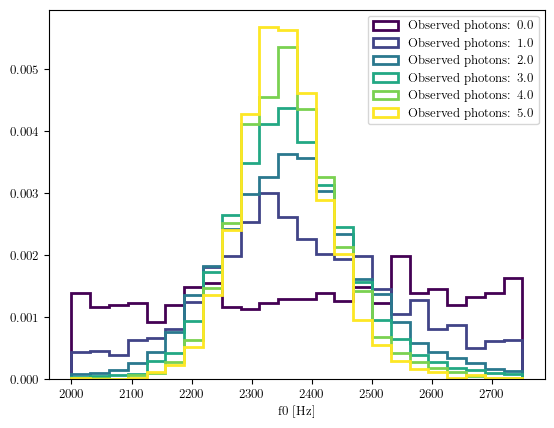

In [16]:
for i in range(len(fits_lorentzian)):

    plt.hist(fits_lorentzian[i].posterior['f0'].values.flatten(), bins=np.linspace(2000, 2750, 25), histtype='step', color=colors[i], label='Observed photons: {}'.format(n_photons[i]), density=True, lw=2)

plt.legend()
plt.xlabel('f0 [Hz]')
plt.savefig('f0_histogram.pdf', bbox_inches='tight')

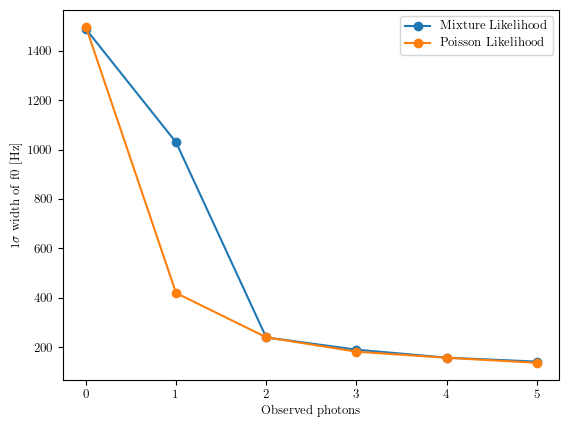

In [18]:
CI_1sigma_width = [jnp.percentile(fits_lorentzian[i].posterior['f0'].values.flatten(), 84) - jnp.percentile(fits_lorentzian[i].posterior['f0'].values.flatten(), 16) for i in range(len(fits_lorentzian))]
CI_1sigma_width_poisson = [jnp.percentile(fits_lorentzian_poisson[i].posterior['f0'].values.flatten(), 84) - jnp.percentile(fits_lorentzian_poisson[i].posterior['f0'].values.flatten(), 16) for i in range(len(fits_lorentzian_poisson))]

#plt.plot(n_photons, CI_1sigma_width_poisson[-1]/(n_photons/5)**(1/1.5), marker='o', label='width $\propto 1/\sqrt{n}$', color='k')
plt.plot(n_photons, CI_1sigma_width, marker='o', label='Mixture Likelihood')
plt.plot(n_photons, CI_1sigma_width_poisson, marker='o', label='Poisson Likelihood')
plt.xlabel('Observed photons')
plt.ylabel(r'1$\sigma$ width of f0 [Hz]')

# ax = plt.gca()
# ax.set_yscale('log')

plt.legend()
plt.savefig('f0_std.pdf', bbox_inches='tight')

In [ ]:
from numpyro.distributions import Poisson, Geometric

print(Geometric(1e-3).log_prob(1), mixture_likelihood.) 

-6.908755779315721 -1.0000004993340834
